## Download data from here:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


chest_xray_data/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── val/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── test/
    ├── NORMAL/
    └── PNEUMONIA/

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = "chest_xray_data"

cuda


In [3]:
# Transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
# Datasets and Loaders

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transform)
val_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transform)
test_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [5]:
# Lightweight CNN

class LightCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 28 * 28, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = LightCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [6]:
# Training with Early Stopping

best_val_acc = 0
patience = 3
counter = 0
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    train_accs.append(train_acc)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Acc=0.8416, Val Acc=0.6875
Epoch 2: Train Acc=0.9130, Val Acc=0.8125
Epoch 3: Train Acc=0.9239, Val Acc=0.5625
Epoch 4: Train Acc=0.9293, Val Acc=0.6250
Epoch 5: Train Acc=0.9354, Val Acc=0.6875
Early stopping triggered.


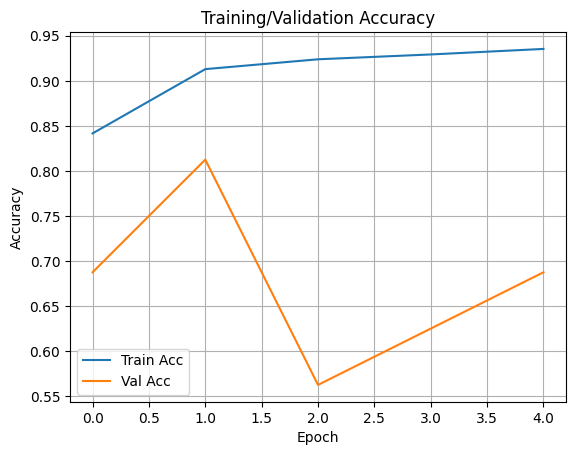

In [7]:
# Accuracy Plot

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Load Best Model

model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [9]:
# Evaluation

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x).argmax(1).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(y.numpy())

# Report
print(classification_report(y_true, y_pred, target_names=train_ds.classes))

              precision    recall  f1-score   support

      NORMAL       0.91      0.53      0.67       234
   PNEUMONIA       0.77      0.97      0.86       390

    accuracy                           0.80       624
   macro avg       0.84      0.75      0.76       624
weighted avg       0.82      0.80      0.79       624



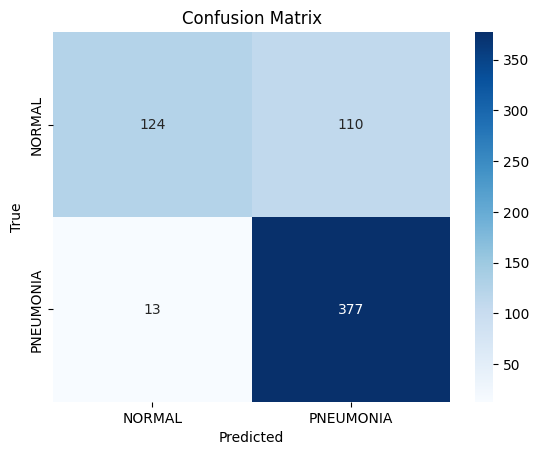

In [10]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()